# Volume and Face Vertical Area: Directly from RAS Ouptut

We discovered that face vertical area and cell volume can be printed directly to HDF output. This notebook is for figuring out how to integrate those outputs. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(1, '../')

In [3]:
import ras2dwq as wq

In [4]:
test_mesh = wq.main('../data/BoxModel.p02.hdf', 0.1, testing=True)

<xarray.DataArray 'volume' (time: 11, nface: 21)>
array([[ 99.9976  ,  99.9976  , 120.704544,  99.9976  ,  99.9976  ,
        120.704544, 116.93161 , 116.93161 , 141.14516 ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ],
       [163.23544 , 159.31796 , 189.3055  , 151.79404 , 146.31963 ,
        172.94516 , 151.64577 , 144.12878 , 170.08661 ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ],
       [162.69063 , 159.26903 , 189.60582 , 152.63911 , 147.75458 ,
        175.06837 , 154.34529 , 147.1344  , 173.92146 ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
          0.      ],
       [162.67073 , 159.24843 , 189.58069 , 152.61806 , 147.73422 ,
   

## Volume Comparison

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.scatter(test_mesh.volume[t], test_mesh.volume_archive[t])
    ax.set_title(f'time = {t}')
    ax.set_xlabel('Volume (HDF Output)')
    ax.set_ylabel('Volume (Calculated)')
    for i, txt in enumerate(test_mesh.volume[t]):
        ax.annotate(i, (test_mesh.volume[t][i].values, test_mesh.volume_archive[t][i].values))
    fig.set_size_inches(10,5)
    plt.show()

The first noticeable difference is that the HDF output calculates a volume for ghost cells. This appears to be positive in the case of cells receiving flow (15, 16, 19), negative for those giving flow, and 0 for those not giving/receiving any flow. This will be useful for some of our calculations.

The calculated vs printed values look pretty similar for real cells! Let's just print those now to see how close our calculated values were:

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.plot(range(0,9), test_mesh.volume[t][0:9] - test_mesh.volume_archive[t][0:9])
    ax.set_title(f'time = {t}')
    ax.set_ylabel('Real Volume - Calculated Volume')
    ax.set_xlabel('Cell #')
    plt.show()

The vaues we calculated were actually quite similar to those printed in the HDF output. 

## Flow Across Face

Users are able to optionally print this to a RAS HDF output file. We previously had calculated the flow across the face by multiplying the velocity by the face vertical area. 

Let's compare those calculated values to the values output by RAS:

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.scatter(test_mesh.edge_vertical_area[t], test_mesh.edge_vertical_area_archive[t])
    ax.set_title(f'time = {t}')
    ax.set_xlabel('Flow Across Face (HDF Output)')
    ax.set_ylabel('Flow Across Face (Calculated)')
    for i, txt in enumerate(test_mesh.advection_coeff[t]):
        ax.annotate(i, (test_mesh.edge_vertical_area[t][i].values, test_mesh.edge_vertical_area_archive[t][i].values))
    fig.set_size_inches(10,5)
    plt.show()

In [ ]:
for t in range(len(test_mesh.time)):
    fig, ax = plt.subplots()
    ax.plot(test_mesh.nedge, test_mesh.edge_vertical_area[t] - test_mesh.edge_vertical_area_archive[t])
    ax.set_title(f'time = {t}')
    ax.set_ylabel('Real Flux - Calculated Flux')
    ax.set_xlabel('Edge #')
    plt.show()

## Error Messages 

In [ ]:
error_mesh = wq.main('../../tests/input_files/Box-Model/BoxModel.p01.hdf', 0.1, testing=True)

Found that when the items are missing (i.e., not printed to the output file) then there is a KeyError. Added an exception to print warning messages for now so that we don't create errors in all of our example notebooks. We can flush this out more (make flow across face calcs more accurate; better error messages). 

## Adjust Sparse Matrix Framework

### Advection Coefficient

Had to adjust the sparse matrix calculation to multiply by negative 1 where the edge velocity is negative, since the flow across the face in RAS does not have a sign. 

Here we test to confirm that everything is still going the way we expect:

In [5]:
input_arr = np.zeros((len(test_mesh['time']), len(test_mesh['nface'])))
input_arr[0][0] = 50

In [6]:
%%time
solved_mesh = wq.wq_simulation(test_mesh, input_arr)

[ 0  1  3  5  6  8 10 11 13 15 17 18 19 22]
[9]
<xarray.DataArray 'volume' (nface: 21)>
array([163.23544, 159.31796, 189.3055 , 151.79404, 146.31963, 172.94516,
       151.64577, 144.12878, 170.08661,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ], dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:01:00
    face_x   (nface) float64 1.641e+06 1.641e+06 ... 1.641e+06 1.642e+06
    face_y   (nface) float64 6.69e+05 6.69e+05 6.69e+05 ... 6.689e+05 6.689e+05
Dimensions without coordinates: nface
Attributes:
    Can Interpolate:            True
    Can Plot:                   True
    Columns:                    Cells
    Coverage:                   Average
    Location:                   Cells
    Maximum Value of Data Set:  189.60582
    Name:                       Volume
    Orientation:                Scalar
    Rows:                       Times
    Units:               

<xarray.DataArray 'load' ()>
array(83.33133062)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:00:00
<xarray.DataArray 'load' ()>
array(12.38487869)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:01:00
<xarray.DataArray 'load' ()>
array(1.32383417)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:02:00
<xarray.DataArray 'load' ()>
array(0.12052236)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:03:00
<xarray.DataArray 'load' ()>
array(0.01000933)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:04:00
<xarray.DataArray 'load' ()>
array(0.00078343)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:05:00
<xarray.DataArray 'load' ()>
array(5.8840215e-05)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:06:00
<xarray.DataArray 'load' ()>
array(4.28734147e-06)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:07:00
<xarray.DataArray 'load' ()>
array(3.05255109e-07)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:08:00
<xarray.DataArr

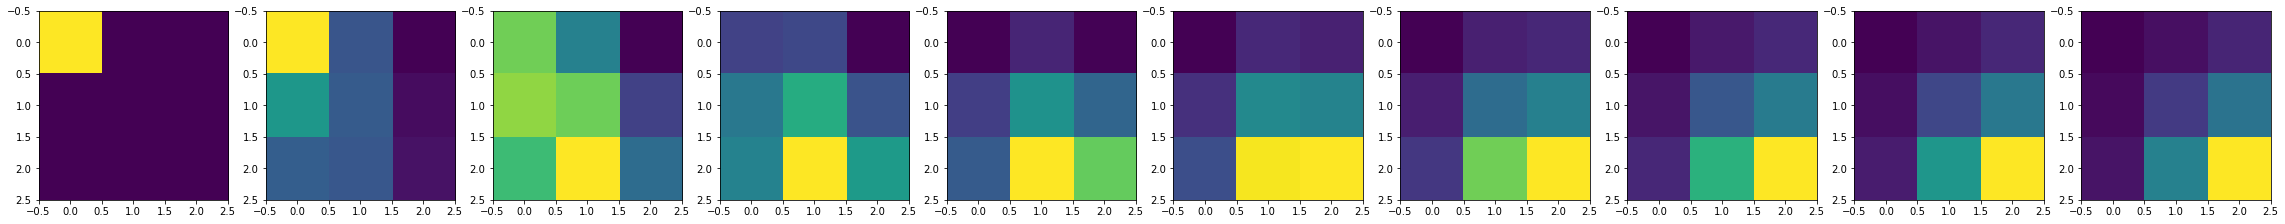

In [7]:
fig, ax = plt.subplots(1,10)
for t in range(len(solved_mesh['time']) - 1):
    ax[t].imshow(solved_mesh['load'][t].values[0:9].reshape(3,3))
    print(solved_mesh['load'][t].sum())
fig.set_size_inches(40,5)

### Ghost Cell Volumes

Will need to integrate these values into the sparse matrix. 

Cells RECEIVING flow can simply take the volume value in the HDF output (positive). Cells flowing IN have negative values. Will need to flip the sign. How will the timesteps work?

Examine Cell #9 (ghost cell)

In [7]:
test_mesh['volume'][1][9]

<xarray.DataArray 'volume' ()>
array(0., dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-01-01T12:01:00
    face_x   float64 1.641e+06
    face_y   float64 6.69e+05
Attributes:
    Can Interpolate:            True
    Can Plot:                   True
    Columns:                    Cells
    Coverage:                   Average
    Location:                   Cells
    Maximum Value of Data Set:  189.60582
    Name:                       Volume
    Orientation:                Scalar
    Rows:                       Times
    Units:                      m

In [ ]:
np.where(test_mesh.edges_face2 >= 9)

In [ ]:
for i in np.where(test_mesh.edges_face2 >= 9):
    print(i)
    plt.plot(range(len(test_mesh.time)), test_mesh['advection_coeff'][:,i], label=i)
    plt.legend()
    plt.show()

In [ ]:
test_mesh.edge_face_connectivity[[17, 19, 22]]

The box model does not have any flow across the faces for ghost cells flowing into the cells. Will need to test this on the Muncie model instead. 